## NonLinear_data

In [ ]:
#import gdown
#! gdown --id 1_COSz5OhHJ6MTFQGeYBHwfSmDIkCkVw5

In [15]:
# 1. Import các thư viện cần thiết
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import torch # type: ignore
import torch.nn as nn # type: ignore
from torch.utils.data import Dataset, DataLoader # type: ignore
import torch.nn.functional as F # type: ignore

from sklearn.model_selection import train_test_split # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore

In [17]:
# 2. Tải bộ dữ liệu
! gdown --id 1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V
To: /content/NonLinear_data.npy
100% 5.57k/5.57k [00:00<00:00, 7.00MB/s]


(300, 2) (300,)
Shape of X:  (300, 2)
Shape of y:  (300,)
Fist 5 rows of X: 
[[0.         0.        ]
 [0.00096008 0.01005528]
 [0.01045864 0.01728405]
 [0.00087922 0.03029027]
 [0.00991727 0.03916803]]
[0 0 0 0 0]


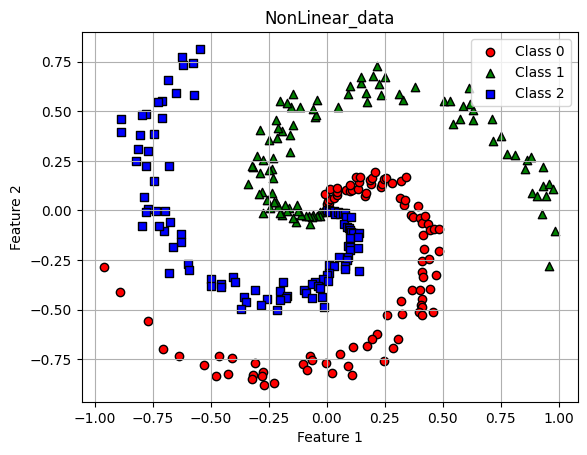

Number of training samples: 210
Number of validation samples: 60
Number of test samples: 30


In [18]:
# 3. Cài đặt giá trị ngẫu nhiên cố định và thiết bị tính toán
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

# 4.Đọc bộ dữ liệu
dataset_path2 = 'NonLinear_data.npy'
data = np.load(dataset_path2, allow_pickle=True).item()
X, y = data['X'], data['labels']
print (X.shape , y. shape )
print('Shape of X: ', X.shape)
print('Shape of y: ', y.shape)
print('Fist 5 rows of X: ')
print(X[:5])
print(y[:5])

# Read dataset and visualize
colors = ['red', 'green', 'blue']
markers = ['o', '^', 's']
plt.figure(figure=(8, 6))
for i, class_label in enumerate(np.unique(y)):
    plt.scatter(
        X[y == class_label, 0],
        X[y == class_label, 1],
        c=colors[i],
        marker=markers[i],
        label=f'Class {class_label}',
        edgecolors='k'
    )
plt.title('NonLinear_data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

# 5.Chia bộ dữ liệu train/val/test
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=random_state, shuffle=is_shuffle)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state, shuffle=is_shuffle)
print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of validation samples: {X_val.shape[0]}')
print(f'Number of test samples: {X_test.shape[0]}')


# 6.Chuẩn hóa đặc trưng đầu vào
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


# 7.Xây dựng DataLoader
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# khai báo luôn tham số batch size
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(
                        train_dataset,
                        batch_size=batch_size,
                        shuffle=True)
val_loader = DataLoader(
                        val_dataset,
                        batch_size=batch_size,
                        shuffle=False)
test_loader = DataLoader(
                        test_dataset,
                        batch_size=batch_size,
                        shuffle=False)


# 8.Xây dựng mạng MLP
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        out = self.output(x)
        return out.squeeze(1)

# thiết lập các tham số cho mạng MLP
input_dims = X_train.shape[1]
output_dims = torch.unique(y_train).shape[0]
hidden_dims = 128
model = MLP(
            input_dims = input_dims,
            hidden_dims = hidden_dims,
            output_dims = output_dims).to(device)


# 9. Khai báo hàm loss và optimizer
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# 10.Xây dựng hàm tính độ chính xác
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct/len(y_true)
    return accuracy

Epoch 1/100, Train Loss: 0.939, Val Loss: 0.864
Epoch 2/100, Train Loss: 0.750, Val Loss: 0.815
Epoch 3/100, Train Loss: 0.715, Val Loss: 0.799
Epoch 4/100, Train Loss: 0.689, Val Loss: 0.791
Epoch 5/100, Train Loss: 0.670, Val Loss: 0.780
Epoch 6/100, Train Loss: 0.654, Val Loss: 0.747
Epoch 7/100, Train Loss: 0.646, Val Loss: 0.724
Epoch 8/100, Train Loss: 0.616, Val Loss: 0.704
Epoch 9/100, Train Loss: 0.616, Val Loss: 0.694
Epoch 10/100, Train Loss: 0.610, Val Loss: 0.666
Epoch 11/100, Train Loss: 0.577, Val Loss: 0.666
Epoch 12/100, Train Loss: 0.596, Val Loss: 0.642
Epoch 13/100, Train Loss: 0.556, Val Loss: 0.625
Epoch 14/100, Train Loss: 0.537, Val Loss: 0.608
Epoch 15/100, Train Loss: 0.521, Val Loss: 0.604
Epoch 16/100, Train Loss: 0.530, Val Loss: 0.587
Epoch 17/100, Train Loss: 0.511, Val Loss: 0.566
Epoch 18/100, Train Loss: 0.498, Val Loss: 0.569
Epoch 19/100, Train Loss: 0.493, Val Loss: 0.540
Epoch 20/100, Train Loss: 0.480, Val Loss: 0.542
Epoch 21/100, Train Loss: 0.4

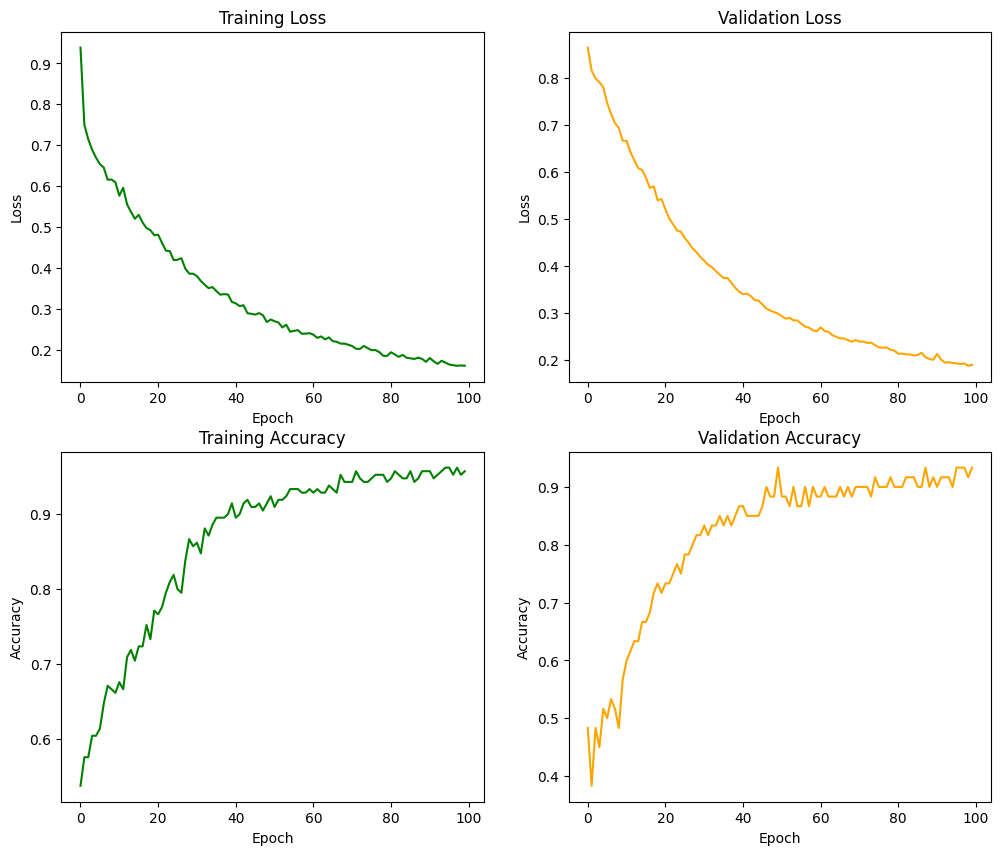

Evaluation on test set: 
Test Accuracy: 0.9333333333333333


In [19]:
# 11.Huấn luyện mô hình
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}')

# trực quan hóa
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

# 12. Đánh giá mô hình
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
test_acc = compute_accuracy(test_predict, test_target)
print('Evaluation on test set: ')
print(f'Test Accuracy: {test_acc}')

## Câu hỏi trắc nghiệm

In [25]:
# Câu 9.1 : Dùng Softmax

# 3. Cài đặt giá trị ngẫu nhiên cố định và thiết bị tính toán
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

# 4.Đọc bộ dữ liệu
dataset_path2 = 'NonLinear_data.npy'
data = np.load(dataset_path2, allow_pickle=True).item()
X, y = data['X'], data['labels']


# 5.Chia bộ dữ liệu train/val/test
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=random_state, shuffle=is_shuffle)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state, shuffle=is_shuffle)


# 6.Chuẩn hóa đặc trưng đầu vào
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


# 7.Xây dựng DataLoader
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# khai báo luôn tham số batch size
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(
                        train_dataset,
                        batch_size=batch_size,
                        shuffle=True)
val_loader = DataLoader(
                        val_dataset,
                        batch_size=batch_size,
                        shuffle=False)
test_loader = DataLoader(
                        test_dataset,
                        batch_size=batch_size,
                        shuffle=False)


# 8.Xây dựng hàm Softmax
class SoftmaxRegression(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(SoftmaxRegression, self).__init__()
        self.linear1 = nn.Linear(input_dims, output_dims)

    def forward(self, x):
        out = self.linear1(x)
        return out

# thiết lập các tham số cho mạng MLP
input_dims = X_train.shape[1]
output_dims = torch.unique(y_train).shape[0]
hidden_dims = 128
model91 = SoftmaxRegression(input_dims=input_dims, output_dims=output_dims).to(device)


# 9. Khai báo hàm loss và optimizer
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model91.parameters(), lr=lr)

# 10.Xây dựng hàm tính độ chính xác
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct/len(y_true)
    return accuracy

# 11.Huấn luyện mô hình
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model91.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model91(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model91.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model91(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)


# 12. Đánh giá mô hình
test_target91 = []
test_predict91 = []
model91.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model91(X_samples)

        test_predict91.append(outputs.cpu())
        test_target91.append(y_samples.cpu())

test_predict91 = torch.cat(test_predict91)
test_target91 = torch.cat(test_target91)
test_acc91 = compute_accuracy(test_predict91, test_target91)
print('Evaluation on test set: ')
print(f'Test Accuracy: {test_acc91}')

Evaluation on test set: 
Test Accuracy: 0.6


In [28]:
# Câu 9.2: Dùng Sigmoid

# 3. Cài đặt giá trị ngẫu nhiên cố định và thiết bị tính toán
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

# 4.Đọc bộ dữ liệu
dataset_path2 = 'NonLinear_data.npy'
data = np.load(dataset_path2, allow_pickle=True).item()
X, y = data['X'], data['labels']


# 5.Chia bộ dữ liệu train/val/test
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=random_state, shuffle=is_shuffle)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state, shuffle=is_shuffle)


# 6.Chuẩn hóa đặc trưng đầu vào
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


# 7.Xây dựng DataLoader
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# khai báo luôn tham số batch size
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(
                        train_dataset,
                        batch_size=batch_size,
                        shuffle=True)
val_loader = DataLoader(
                        val_dataset,
                        batch_size=batch_size,
                        shuffle=False)
test_loader = DataLoader(
                        test_dataset,
                        batch_size=batch_size,
                        shuffle=False)


# 8.Xây dựng hàm Sigmoid
class MLP_Sigmoid(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP_Sigmoid, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.sigmoid = nn.Sigmoid()
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = self.linear1(x)
        x = self.sigmoid(x)  # Use Sigmoid activation here
        out = self.output(x)
        return out.squeeze(1)

# thiết lập các tham số cho mạng MLP
input_dims = X_train.shape[1]
output_dims = torch.unique(y_train).shape[0]
hidden_dims = 128
model92 = MLP_Sigmoid(input_dims=input_dims,
                      hidden_dims=hidden_dims,
                      output_dims=output_dims).to(device)


# 9. Khai báo hàm loss và optimizer
lr = 1e-2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model92.parameters(), lr=lr)

# 10.Xây dựng hàm tính độ chính xác
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct/len(y_true)
    return accuracy

# 11.Huấn luyện mô hình
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model92.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model92(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model92.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model92(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)


# 12. Đánh giá mô hình
test_target92 = []
test_predict92 = []
model92.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model92(X_samples)

        test_predict92.append(outputs.cpu())
        test_target92.append(y_samples.cpu())

test_predict92 = torch.cat(test_predict92)
test_target92 = torch.cat(test_target92)
test_acc92 = compute_accuracy(test_predict92, test_target92)
print('Evaluation on test set: ')
print(f'Test Accuracy: {test_acc92}')

Evaluation on test set: 
Test Accuracy: 0.6333333333333333


In [30]:
# Câu 9.3: Dùng Tanh

# 3. Cài đặt giá trị ngẫu nhiên cố định và thiết bị tính toán
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

# 4.Đọc bộ dữ liệu
dataset_path2 = 'NonLinear_data.npy'
data = np.load(dataset_path2, allow_pickle=True).item()
X, y = data['X'], data['labels']


# 5.Chia bộ dữ liệu train/val/test
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=random_state, shuffle=is_shuffle)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state, shuffle=is_shuffle)


# 6.Chuẩn hóa đặc trưng đầu vào
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


# 7.Xây dựng DataLoader
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# khai báo luôn tham số batch size
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(
                        train_dataset,
                        batch_size=batch_size,
                        shuffle=True)
val_loader = DataLoader(
                        val_dataset,
                        batch_size=batch_size,
                        shuffle=False)
test_loader = DataLoader(
                        test_dataset,
                        batch_size=batch_size,
                        shuffle=False)


# 8.Xây dựng hàm Tanh
class MLP_Tanh(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP_Tanh, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.tanh = nn.Tanh()
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = self.linear1(x)
        x = self.tanh(x)  # Use Tanh activation here
        out = self.output(x)
        return out

# thiết lập các tham số cho mạng MLP
input_dims = X_train.shape[1]
output_dims = torch.unique(y_train).shape[0]
hidden_dims = 128
model93 =MLP_Tanh(input_dims=input_dims,
                  hidden_dims=128,
                  output_dims=output_dims).to(device)

# 9. Khai báo hàm loss và optimizer
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model93.parameters(), lr=lr)

# 10.Xây dựng hàm tính độ chính xác
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct/len(y_true)
    return accuracy

# 11.Huấn luyện mô hình
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model93.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model93(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model93.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model93(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)


# 12. Đánh giá mô hình
test_target93 = []
test_predict93 = []
model93.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model93(X_samples)

        test_predict93.append(outputs.cpu())
        test_target93.append(y_samples.cpu())

test_predict93 = torch.cat(test_predict93)
test_target93 = torch.cat(test_target93)
test_acc93 = compute_accuracy(test_predict93, test_target93)
print('Evaluation on test set: ')
print(f'Test Accuracy: {test_acc93}')

Evaluation on test set: 
Test Accuracy: 0.9


In [31]:
# Câu 9.4 : Dùng Tanh và hidden_dims = 512

# 3. Cài đặt giá trị ngẫu nhiên cố định và thiết bị tính toán
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

# 4.Đọc bộ dữ liệu
dataset_path2 = 'NonLinear_data.npy'
data = np.load(dataset_path2, allow_pickle=True).item()
X, y = data['X'], data['labels']


# 5.Chia bộ dữ liệu train/val/test
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=random_state, shuffle=is_shuffle)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state, shuffle=is_shuffle)


# 6.Chuẩn hóa đặc trưng đầu vào
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


# 7.Xây dựng DataLoader
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# khai báo luôn tham số batch size
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(
                        train_dataset,
                        batch_size=batch_size,
                        shuffle=True)
val_loader = DataLoader(
                        val_dataset,
                        batch_size=batch_size,
                        shuffle=False)
test_loader = DataLoader(
                        test_dataset,
                        batch_size=batch_size,
                        shuffle=False)


# 8.Xây dựng hàm Tanh, hidden 512
class MLP_Tanh_Large(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP_Tanh_Large, self).__init__()
        # Define layers here
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.tanh = nn.Tanh()
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = self.linear1(x)
        x = self.tanh(x)  # Use Tanh activation here
        out = self.output(x)
        return out

# thiết lập các tham số cho mạng MLP
input_dims = X_train.shape[1]
output_dims = torch.unique(y_train).shape[0]
hidden_dims94 = 512
model94 = MLP_Tanh_Large(input_dims=input_dims,
                         hidden_dims=hidden_dims94,
                         output_dims=output_dims).to(device)

# 9. Khai báo hàm loss và optimizer
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model94.parameters(), lr=lr)

# 10.Xây dựng hàm tính độ chính xác
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct/len(y_true)
    return accuracy

# 11.Huấn luyện mô hình
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model94.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model94(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model94.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model94(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)


# 12. Đánh giá mô hình
test_target94 = []
test_predict94 = []
model94.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model94(X_samples)

        test_predict94.append(outputs.cpu())
        test_target94.append(y_samples.cpu())

test_predict94 = torch.cat(test_predict94)
test_target94 = torch.cat(test_target94)
test_acc94 = compute_accuracy(test_predict94, test_target94)
print('Evaluation on test set: ')
print(f'Test Accuracy: {test_acc94}')

Evaluation on test set: 
Test Accuracy: 0.9333333333333333
